In [1]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn import datasets
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import scipy.io as sio
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# 4. Taiwanese Bankruptcy Prediction dataset #

## Linear SVM ##

In [3]:
# Calculate error given feature vectors X and labels Y
def calc_error(X, Y, classifier):
    Y_pred = classifier.predict(X)
    e = 1 - accuracy_score(Y, Y_pred)
    return e

In [4]:
# Bankruptcy dataset
# 20-80 partition
%pip install ucimlrepo

from ucimlrepo import fetch_ucirepo 
  
# Fetch dataset 
taiwanese_bankruptcy = fetch_ucirepo(id=572) 

pd.options.mode.copy_on_write = True
  
# Data 
df = taiwanese_bankruptcy.data.features.join(taiwanese_bankruptcy.data.targets)
df = df.dropna(subset=["Bankrupt?"])

X = df.drop(columns=["Bankrupt?"]).to_numpy()

Y = df["Bankrupt?"].to_numpy().astype(float).copy()
Y[Y==0] = -1

# Shuffle
X_and_Y = np.hstack((X, Y.reshape(-1,1)))
np.random.seed(1)
np.random.shuffle(X_and_Y)

X_shuffled = X_and_Y[:, :-1]
Y_shuffled = X_and_Y[:, -1]

# Original dataset has 6819 instances
X_train = X_shuffled[:1363]                         # Shape: (1363, 95)
Y_train = Y_shuffled[:1363]                         # Shape: (1363, )
X_test  = X_shuffled[1363:]                         # Shape: (5456, 95)
Y_test  = Y_shuffled[1363:]                         # Shape: (5456, )
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

Note: you may need to restart the kernel to use updated packages.
(1363, 95)
(1363,)
(5456, 95)
(5456,)


In [5]:
C_list = [0.01, 0.1, 1, 10, 100]

kf = KFold(n_splits=5, shuffle=True, random_state=0)
cv_errors = np.zeros(len(C_list))

best_error = 1.0
opt_C = None

for i, C in enumerate(C_list):

    fold_errors = []

    for train_index, val_index in kf.split(X_train):
        X_tr, X_va = X_train[train_index], X_train[val_index]
        Y_tr, Y_va = Y_train[train_index], Y_train[val_index]

        # Standardize
        scaler = StandardScaler()
        X_tr = scaler.fit_transform(X_tr)
        X_va = scaler.transform(X_va)

        # Linear SVM
        clf = LinearSVC(C=C, max_iter=5000)
        clf.fit(X_tr, Y_tr)

        fold_errors.append(calc_error(X_va, Y_va, clf))

    cv_error = np.mean(fold_errors)
    cv_errors[i] = cv_error

    if cv_error < best_error:
        best_error = cv_error
        opt_C = C

# Train classifier on training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

opt_classifier = LinearSVC(C=opt_C, max_iter=5000)
opt_classifier.fit(X_train_scaled, Y_train)

# Test error
X_test_scaled = scaler.transform(X_test)
train_error = calc_error(X_train_scaled, Y_train, opt_classifier)
test_error = calc_error(X_test_scaled, Y_test, opt_classifier)

print("Best CV error =", best_error)
print("C* =", opt_C)
print("Training error =", train_error)
print("Test error =", test_error)

Best CV error = 0.0432826976944624
C* = 0.01
Training error = 0.03374908290535583
Test error = 0.03189149560117299


In [6]:
# 50-50 partition 

# Fetch dataset 
taiwanese_bankruptcy = fetch_ucirepo(id=572) 

pd.options.mode.copy_on_write = True
  
# Data 
df = taiwanese_bankruptcy.data.features.join(taiwanese_bankruptcy.data.targets)
df = df.dropna(subset=["Bankrupt?"])

X = df.drop(columns=["Bankrupt?"]).to_numpy()

Y = df["Bankrupt?"].to_numpy().astype(float).copy()
Y[Y==0] = -1

# Shuffle
X_and_Y = np.hstack((X, Y.reshape(-1,1)))
np.random.seed(1)
np.random.shuffle(X_and_Y)

X_shuffled = X_and_Y[:, :-1]
Y_shuffled = X_and_Y[:, -1]

# Original dataset has 6819 instances
X_train = X_shuffled[:3409]                         # Shape: (3409, 95)
Y_train = Y_shuffled[:3409]                         # Shape: (3409, )
X_test  = X_shuffled[3409:]                         # Shape: (3410, 95)
Y_test  = Y_shuffled[3409:]                         # Shape: (3410, )
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(3409, 95)
(3409,)
(3410, 95)
(3410,)


In [7]:
C_list = [0.01, 0.1, 1, 10, 100]

kf = KFold(n_splits=5, shuffle=True, random_state=0)
cv_errors = np.zeros(len(C_list))

best_error = 1.0
opt_C = None

for i, C in enumerate(C_list):

    fold_errors = []

    for train_index, val_index in kf.split(X_train):
        X_tr, X_va = X_train[train_index], X_train[val_index]
        Y_tr, Y_va = Y_train[train_index], Y_train[val_index]

        # Standardize
        scaler = StandardScaler()
        X_tr = scaler.fit_transform(X_tr)
        X_va = scaler.transform(X_va)

        # Linear SVM
        clf = LinearSVC(C=C, max_iter=5000)
        clf.fit(X_tr, Y_tr)

        fold_errors.append(calc_error(X_va, Y_va, clf))

    cv_error = np.mean(fold_errors)
    cv_errors[i] = cv_error

    if cv_error < best_error:
        best_error = cv_error
        opt_C = C

# Train classifier on training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

opt_classifier = LinearSVC(C=opt_C, max_iter=5000)
opt_classifier.fit(X_train_scaled, Y_train)

# Test error
X_test_scaled = scaler.transform(X_test)
train_error = calc_error(X_train_scaled, Y_train, opt_classifier)
test_error = calc_error(X_test_scaled, Y_test, opt_classifier)

print("Best CV error =", best_error)
print("C* =", opt_C)
print("Training error =", train_error)
print("Test error =", test_error)

Best CV error = 0.03138691160575484
C* = 0.01
Training error = 0.02757406864183043
Test error = 0.03372434017595305


In [8]:
# 80-20 partition 

# Fetch dataset 
taiwanese_bankruptcy = fetch_ucirepo(id=572) 

pd.options.mode.copy_on_write = True
  
# Data 
df = taiwanese_bankruptcy.data.features.join(taiwanese_bankruptcy.data.targets)
df = df.dropna(subset=["Bankrupt?"])

X = df.drop(columns=["Bankrupt?"]).to_numpy()

Y = df["Bankrupt?"].to_numpy().astype(float).copy()
Y[Y==0] = -1

# Shuffle
X_and_Y = np.hstack((X, Y.reshape(-1,1)))
np.random.seed(1)
np.random.shuffle(X_and_Y)

X_shuffled = X_and_Y[:, :-1]
Y_shuffled = X_and_Y[:, -1]

# Original dataset has 6819 instances
X_train = X_shuffled[:5455]                         # Shape: (5455, 95)
Y_train = Y_shuffled[:5455]                         # Shape: (5455, )
X_test  = X_shuffled[5455:]                         # Shape: (1364, 95)
Y_test  = Y_shuffled[5455:]                         # Shape: (1364, )
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(5455, 95)
(5455,)
(1364, 95)
(1364,)


In [9]:
C_list = [0.01, 0.1, 1, 10, 100]

kf = KFold(n_splits=5, shuffle=True, random_state=0)
cv_errors = np.zeros(len(C_list))

best_error = 1.0
opt_C = None

for i, C in enumerate(C_list):

    fold_errors = []

    for train_index, val_index in kf.split(X_train):
        X_tr, X_va = X_train[train_index], X_train[val_index]
        Y_tr, Y_va = Y_train[train_index], Y_train[val_index]

        # Standardize
        scaler = StandardScaler()
        X_tr = scaler.fit_transform(X_tr)
        X_va = scaler.transform(X_va)

        # Linear SVM
        clf = LinearSVC(C=C, max_iter=5000)
        clf.fit(X_tr, Y_tr)

        fold_errors.append(calc_error(X_va, Y_va, clf))

    cv_error = np.mean(fold_errors)
    cv_errors[i] = cv_error

    if cv_error < best_error:
        best_error = cv_error
        opt_C = C

# Train classifier on training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

opt_classifier = LinearSVC(C=opt_C, max_iter=5000)
opt_classifier.fit(X_train_scaled, Y_train)

# Test error
X_test_scaled = scaler.transform(X_test)
train_error = calc_error(X_train_scaled, Y_train, opt_classifier)
test_error = calc_error(X_test_scaled, Y_test, opt_classifier)

print("Best CV error =", best_error)
print("C* =", opt_C)
print("Training error =", train_error)
print("Test error =", test_error)

Best CV error = 0.03244729605866179
C* = 1
Training error = 0.027864344637946847
Test error = 0.035190615835777095


## Decision Tree - Buntine tree ID3 (using Scikit-Learn) ##

In [10]:
%config InlineBackend.figure_format = 'retina'
import scipy.io as sio
from sklearn import tree
from sklearn.model_selection import GridSearchCV

In [11]:
# Draw heatmaps for result of grid search
def draw_heatmap(errors, D_list, title):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
    ax.collections[0].colorbar.set_label('error')
    ax.set(ylabel='max depth D')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title(title)
    plt.show()

In [12]:
# 20-80 partition
  
# Fetch dataset 
taiwanese_bankruptcy = fetch_ucirepo(id=572) 

pd.options.mode.copy_on_write = True
  
# Data 
df = taiwanese_bankruptcy.data.features.join(taiwanese_bankruptcy.data.targets)
df = df.dropna(subset=["Bankrupt?"])

X = df.drop(columns=["Bankrupt?"]).to_numpy()

Y = df["Bankrupt?"].to_numpy().astype(float).copy()
Y[Y==0] = -1

# Shuffle
X_and_Y = np.hstack((X, Y.reshape(-1,1)))
np.random.seed(1)
np.random.shuffle(X_and_Y)

X_shuffled = X_and_Y[:, :-1]
Y_shuffled = X_and_Y[:, -1]

# Original dataset has 6819 instances
X_train = X_shuffled[:1363]                         # Shape: (1363, 95)
Y_train = Y_shuffled[:1363]                         # Shape: (1363, )
X_test  = X_shuffled[1363:]                         # Shape: (5456, 95)
Y_test  = Y_shuffled[1363:]                         # Shape: (5456, )
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1363, 95)
(1363,)
(5456, 95)
(5456,)


In [13]:
estimator = tree.DecisionTreeClassifier(criterion="entropy", random_state=1)

D_list = [1, 2, 3, 4, 5]
param_grid = {
    'max_depth': D_list,
}

grid_search = GridSearchCV(
    estimator,
    param_grid,
    cv=10,
    scoring='accuracy')

grid_search.fit(X_train, Y_train)

,estimator,DecisionTreeC...andom_state=1)
,param_grid,"{'max_depth': [1, 2, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'entropy'


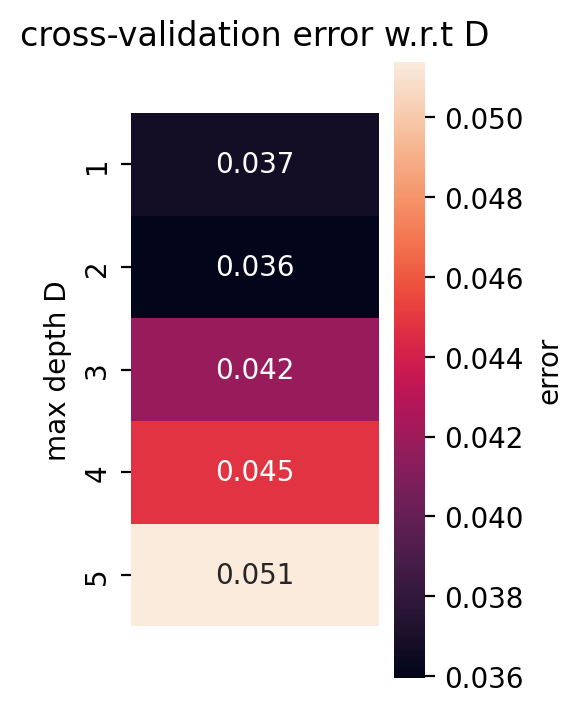

Best max depth D: 2
Training error = 0.03668378576669107
Cross-validated validation error = 0.035954272219836825
Testing error = 0.03115835777126097


In [14]:
# Draw heatmaps of cross-validation errors (in cross-validation)
cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')

# Show the best max depth
best_max_depth = grid_search.best_params_['max_depth']
print("Best max depth D: {}".format(best_max_depth))

# Calculate the errors
train_pred = grid_search.best_estimator_.predict(X_train)
train_error = 1 - accuracy_score(Y_train, train_pred)
cv_val_accuracy = grid_search.best_score_
cv_val_error = 1 - cv_val_accuracy
test_pred = grid_search.best_estimator_.predict(X_test)
test_error = 1 - accuracy_score(Y_test, test_pred)
print("Training error =", train_error)
print("Cross-validated validation error =", cv_val_error)
print("Testing error =", test_error)

In [15]:
# 50-50 partition 

# Fetch dataset 
taiwanese_bankruptcy = fetch_ucirepo(id=572) 

pd.options.mode.copy_on_write = True
  
# Data 
df = taiwanese_bankruptcy.data.features.join(taiwanese_bankruptcy.data.targets)
df = df.dropna(subset=["Bankrupt?"])

X = df.drop(columns=["Bankrupt?"]).to_numpy()

Y = df["Bankrupt?"].to_numpy().astype(float).copy()
Y[Y==0] = -1

# Shuffle
X_and_Y = np.hstack((X, Y.reshape(-1,1)))
np.random.seed(1)
np.random.shuffle(X_and_Y)

X_shuffled = X_and_Y[:, :-1]
Y_shuffled = X_and_Y[:, -1]

# Original dataset has 6819 instances
X_train = X_shuffled[:3409]                         # Shape: (3409, 95)
Y_train = Y_shuffled[:3409]                         # Shape: (3409, )
X_test  = X_shuffled[3409:]                         # Shape: (3410, 95)
Y_test  = Y_shuffled[3409:]                         # Shape: (3410, )
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(3409, 95)
(3409,)
(3410, 95)
(3410,)


In [16]:
estimator = tree.DecisionTreeClassifier(criterion="entropy", random_state=1)

D_list = [1, 2, 3, 4, 5]
param_grid = {
    'max_depth': D_list,
}

grid_search = GridSearchCV(
    estimator,
    param_grid,
    cv=10,
    scoring='accuracy')

grid_search.fit(X_train, Y_train)

,estimator,DecisionTreeC...andom_state=1)
,param_grid,"{'max_depth': [1, 2, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'entropy'


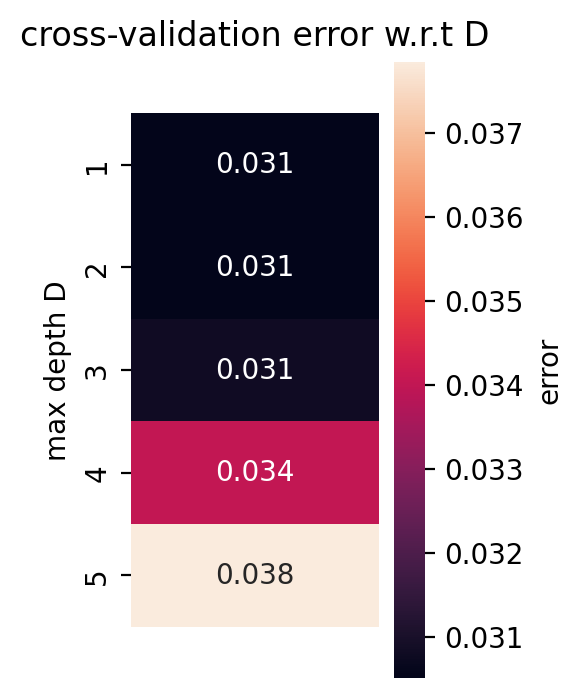

Best max depth D: 1
Training error = 0.030507480199472026
Cross-validated validation error = 0.030507158875280327
Testing error = 0.034017595307917925


In [17]:
# Draw heatmaps of cross-validation errors (in cross-validation)
cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')

# Show the best max depth
best_max_depth = grid_search.best_params_['max_depth']
print("Best max depth D: {}".format(best_max_depth))

# Calculate the errors
train_pred = grid_search.best_estimator_.predict(X_train)
train_error = 1 - accuracy_score(Y_train, train_pred)
cv_val_accuracy = grid_search.best_score_
cv_val_error = 1 - cv_val_accuracy
test_pred = grid_search.best_estimator_.predict(X_test)
test_error = 1 - accuracy_score(Y_test, test_pred)
print("Training error =", train_error)
print("Cross-validated validation error =", cv_val_error)
print("Testing error =", test_error)

In [18]:
# 80-20 partition 

# Fetch dataset 
taiwanese_bankruptcy = fetch_ucirepo(id=572) 

pd.options.mode.copy_on_write = True
  
# Data 
df = taiwanese_bankruptcy.data.features.join(taiwanese_bankruptcy.data.targets)
df = df.dropna(subset=["Bankrupt?"])

X = df.drop(columns=["Bankrupt?"]).to_numpy()

Y = df["Bankrupt?"].to_numpy().astype(float).copy()
Y[Y==0] = -1

# Shuffle
X_and_Y = np.hstack((X, Y.reshape(-1,1)))
np.random.seed(1)
np.random.shuffle(X_and_Y)

X_shuffled = X_and_Y[:, :-1]
Y_shuffled = X_and_Y[:, -1]

# Original dataset has 6819 instances
X_train = X_shuffled[:5455]                         # Shape: (5455, 95)
Y_train = Y_shuffled[:5455]                         # Shape: (5455, )
X_test  = X_shuffled[5455:]                         # Shape: (1364, 95)
Y_test  = Y_shuffled[5455:]                         # Shape: (1364, )
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(5455, 95)
(5455,)
(1364, 95)
(1364,)


In [21]:
estimator = tree.DecisionTreeClassifier(criterion="entropy", random_state=1)

D_list = [1, 2, 3, 4, 5]
param_grid = {
    'max_depth': D_list,
}

grid_search = GridSearchCV(
    estimator,
    param_grid,
    cv=10,
    scoring='accuracy')

grid_search.fit(X_train, Y_train)

,estimator,DecisionTreeC...andom_state=1)
,param_grid,"{'max_depth': [1, 2, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'entropy'


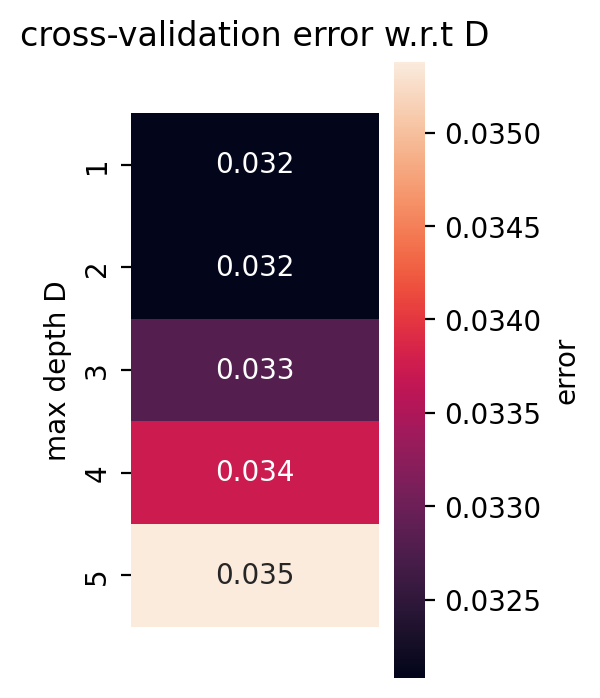

Best max depth D: 1
Training error = 0.03208065994500453
Cross-validated validation error = 0.03207984675874587
Testing error = 0.032991202346041026


In [22]:
# Draw heatmaps of cross-validation errors (in cross-validation)
cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')

# Show the best max depth
best_max_depth = grid_search.best_params_['max_depth']
print("Best max depth D: {}".format(best_max_depth))

# Calculate the errors
train_pred = grid_search.best_estimator_.predict(X_train)
train_error = 1 - accuracy_score(Y_train, train_pred)
cv_val_accuracy = grid_search.best_score_
cv_val_error = 1 - cv_val_accuracy
test_pred = grid_search.best_estimator_.predict(X_test)
test_error = 1 - accuracy_score(Y_test, test_pred)
print("Training error =", train_error)
print("Cross-validated validation error =", cv_val_error)
print("Testing error =", test_error)

## Random Forests ##

In [23]:
# 20-80 partition
 
# Fetch dataset 
taiwanese_bankruptcy = fetch_ucirepo(id=572) 

pd.options.mode.copy_on_write = True
  
# Data 
df = taiwanese_bankruptcy.data.features.join(taiwanese_bankruptcy.data.targets)
df = df.dropna(subset=["Bankrupt?"])

X = df.drop(columns=["Bankrupt?"]).to_numpy()

Y = df["Bankrupt?"].to_numpy().astype(float).copy()
Y[Y==0] = -1

# Shuffle
X_and_Y = np.hstack((X, Y.reshape(-1,1)))
np.random.seed(1)
np.random.shuffle(X_and_Y)

X_shuffled = X_and_Y[:, :-1]
Y_shuffled = X_and_Y[:, -1]

# Original dataset has 6819 instances
X_train = X_shuffled[:1363]                         # Shape: (1363, 95)
Y_train = Y_shuffled[:1363]                         # Shape: (1363, )
X_test  = X_shuffled[1363:]                         # Shape: (5456, 95)
Y_test  = Y_shuffled[1363:]                         # Shape: (5456, )
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1363, 95)
(1363,)
(5456, 95)
(5456,)


In [24]:
n_list = [1,2,4,6,8,12,16,20]

param_grid = {
    'max_features': n_list
}

clf = RandomForestClassifier(
    n_estimators=1024,
    bootstrap=True,
    random_state=1,
    n_jobs=-1,
    max_depth=20
)

grid_search = GridSearchCV(
    clf,
    param_grid,
    cv=5,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1
)

grid_search.fit(X_train, Y_train)

best_n = grid_search.best_params_['max_features']
print("Best n =", best_n)

Best n = 1


In [25]:
train_pred = grid_search.best_estimator_.predict(X_train)
train_error = 1 - accuracy_score(Y_train, train_pred)
print("Training error =", train_error)
val_error = 1 - grid_search.best_score_
print("Cross-validated validation error =", val_error)
test_pred = grid_search.best_estimator_.predict(X_test)
test_error = 1 - accuracy_score(Y_test, test_pred)
print("Test error =", test_error)

Training error = 0.0
Cross-validated validation error = 0.035951303598362516
Test error = 0.030425219941348947


In [26]:
# 50-50 partition 

# Fetch dataset 
taiwanese_bankruptcy = fetch_ucirepo(id=572) 

pd.options.mode.copy_on_write = True
  
# Data 
df = taiwanese_bankruptcy.data.features.join(taiwanese_bankruptcy.data.targets)
df = df.dropna(subset=["Bankrupt?"])

X = df.drop(columns=["Bankrupt?"]).to_numpy()

Y = df["Bankrupt?"].to_numpy().astype(float).copy()
Y[Y==0] = -1

# Shuffle
X_and_Y = np.hstack((X, Y.reshape(-1,1)))
np.random.seed(1)
np.random.shuffle(X_and_Y)

X_shuffled = X_and_Y[:, :-1]
Y_shuffled = X_and_Y[:, -1]

# Original dataset has 6819 instances
X_train = X_shuffled[:3409]                         # Shape: (3409, 95)
Y_train = Y_shuffled[:3409]                         # Shape: (3409, )
X_test  = X_shuffled[3409:]                         # Shape: (3410, 95)
Y_test  = Y_shuffled[3409:]                         # Shape: (3410, )
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(3409, 95)
(3409,)
(3410, 95)
(3410,)


In [29]:
n_list = [1,2,4,6,8,12,16,20]

param_grid = {
    'max_features': n_list
}

clf = RandomForestClassifier(
    n_estimators=1024,
    bootstrap=True,
    random_state=1,
    n_jobs=-1,
    max_depth=20
)

grid_search = GridSearchCV(
    clf,
    param_grid,
    cv=5,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1
)

grid_search.fit(X_train, Y_train)

best_n = grid_search.best_params_['max_features']
print("Best n =", best_n)

Best n = 20


In [28]:
train_pred = grid_search.best_estimator_.predict(X_train)
train_error = 1 - accuracy_score(Y_train, train_pred)
print("Training error =", train_error)
val_error = 1 - grid_search.best_score_
print("Cross-validated validation error =", val_error)
test_pred = grid_search.best_estimator_.predict(X_test)
test_error = 1 - accuracy_score(Y_test, test_pred)
print("Test error =", test_error)

Training error = 0.0
Cross-validated validation error = 0.02698722337773063
Test error = 0.03196480938416424


In [30]:
# 80-20 partition 

# Fetch dataset 
taiwanese_bankruptcy = fetch_ucirepo(id=572) 

pd.options.mode.copy_on_write = True
  
# Data 
df = taiwanese_bankruptcy.data.features.join(taiwanese_bankruptcy.data.targets)
df = df.dropna(subset=["Bankrupt?"])

X = df.drop(columns=["Bankrupt?"]).to_numpy()

Y = df["Bankrupt?"].to_numpy().astype(float).copy()
Y[Y==0] = -1

# Shuffle
X_and_Y = np.hstack((X, Y.reshape(-1,1)))
np.random.seed(1)
np.random.shuffle(X_and_Y)

X_shuffled = X_and_Y[:, :-1]
Y_shuffled = X_and_Y[:, -1]

# Original dataset has 6819 instances
X_train = X_shuffled[:5455]                         # Shape: (5455, 95)
Y_train = Y_shuffled[:5455]                         # Shape: (5455, )
X_test  = X_shuffled[5455:]                         # Shape: (1364, 95)
Y_test  = Y_shuffled[5455:]                         # Shape: (1364, )
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(5455, 95)
(5455,)
(1364, 95)
(1364,)


In [33]:
n_list = [1,2,4,6,8,12,16,20]

param_grid = {
    'max_features': n_list
}

clf = RandomForestClassifier(
    n_estimators=1024,
    bootstrap=True,
    random_state=1,
    n_jobs=-1,
    max_depth=20
)

grid_search = GridSearchCV(
    clf,
    param_grid,
    cv=5,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1
)

grid_search.fit(X_train, Y_train)

best_n = grid_search.best_params_['max_features']
print("Best n =", best_n)

Best n = 12


In [34]:
train_pred = grid_search.best_estimator_.predict(X_train)
train_error = 1 - accuracy_score(Y_train, train_pred)
print("Training error =", train_error)
val_error = 1 - grid_search.best_score_
print("Cross-validated validation error =", val_error)
test_pred = grid_search.best_estimator_.predict(X_test)
test_error = 1 - accuracy_score(Y_test, test_pred)
print("Test error =", test_error)

Training error = 0.0
Cross-validated validation error = 0.02933088909257564
Test error = 0.030058651026392935


## Classification Error Graph ##

In [35]:
# 80-20 partition 

# Fetch dataset 
taiwanese_bankruptcy = fetch_ucirepo(id=572) 

pd.options.mode.copy_on_write = True
  
# Data 
df = taiwanese_bankruptcy.data.features.join(taiwanese_bankruptcy.data.targets)
df = df.dropna(subset=["Bankrupt?"])

X = df.drop(columns=["Bankrupt?"]).to_numpy()

Y = df["Bankrupt?"].to_numpy().astype(float).copy()
Y[Y==0] = -1

# Shuffle
X_and_Y = np.hstack((X, Y.reshape(-1,1)))
np.random.seed(1)
np.random.shuffle(X_and_Y)

X_shuffled = X_and_Y[:, :-1]
Y_shuffled = X_and_Y[:, -1]

# Original dataset has 6819 instances
X_train = X_shuffled[:5455]                         # Shape: (5455, 95)
Y_train = Y_shuffled[:5455]                         # Shape: (5455, )
X_test  = X_shuffled[5455:]                         # Shape: (1364, 95)
Y_test  = Y_shuffled[5455:]                         # Shape: (1364, )
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(5455, 95)
(5455,)
(1364, 95)
(1364,)


In [36]:
n_list = [1,2,4,6,8,12,16,20]

param_grid = {
    'max_features': n_list
}

clf = RandomForestClassifier(
    n_estimators=1024,
    bootstrap=True,
    random_state=1,
    n_jobs=-1,
    max_depth=20
)

grid_search = GridSearchCV(
    clf,
    param_grid,
    cv=5,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1
)

grid_search.fit(X_train, Y_train)

best_n = grid_search.best_params_['max_features']
print("Best n =", best_n)

Best n = 12


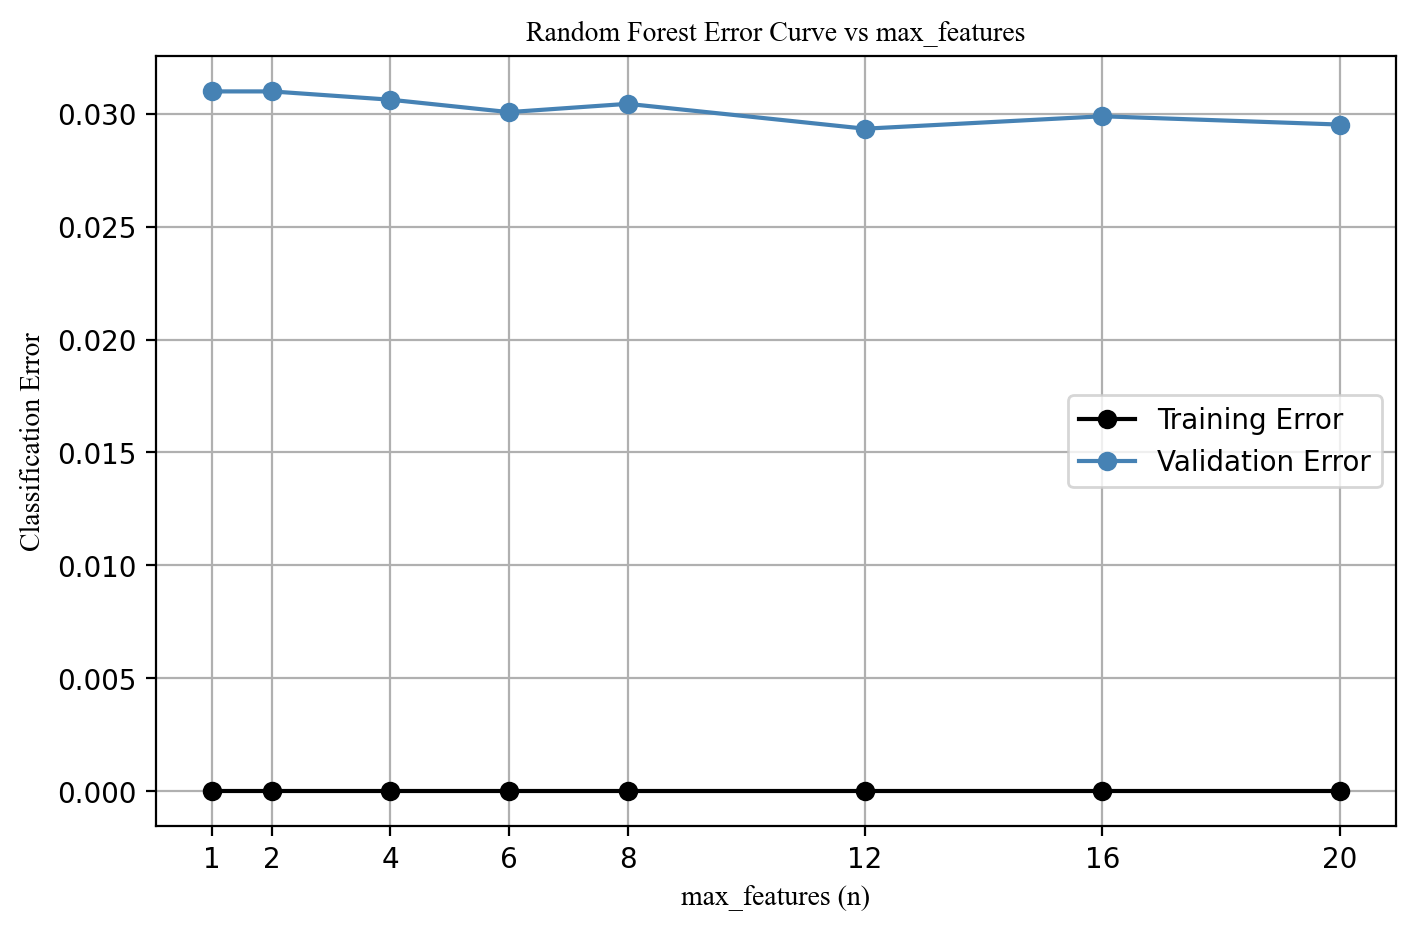

In [38]:
import numpy as np
import matplotlib.pyplot as plt

train_accuracy = grid_search.cv_results_["mean_train_score"]
val_accuracy = grid_search.cv_results_["mean_test_score"]

train_error = 1 - train_accuracy
val_error = 1 - val_accuracy

plt.figure(figsize=(8,5))
plt.plot(n_list, train_error, color='black', marker='o', label='Training Error')
plt.plot(n_list, val_error, color='steelblue', marker='o', label='Validation Error')

plt.xlabel("max_features (n)", font="Times New Roman")
plt.ylabel("Classification Error", font="Times New Roman")
plt.title("Random Forest Error Curve vs max_features", font="Times New Roman")
plt.xticks(n_list)
plt.grid(True)
plt.legend()
plt.show()

In [39]:
train_pred = grid_search.best_estimator_.predict(X_train)
train_error = 1 - accuracy_score(Y_train, train_pred)
print("Training error =", train_error)
val_error = 1 - grid_search.best_score_
print("Cross-validated validation error =", val_error)
test_pred = grid_search.best_estimator_.predict(X_test)
test_error = 1 - accuracy_score(Y_test, test_pred)
print("Test error =", test_error)

Training error = 0.0
Cross-validated validation error = 0.02933088909257564
Test error = 0.030058651026392935
